## 1. Video Game A/B Testing
<p>Progressing through the levels of a game, the players encounter gates that force them to either wait a non-trivial amount of time or make an in-app purchase to progress.</p>

<p>Along with driving the in-app purchases, gates serve the important purpose of giving players an enforced break from playing the game, which results in increasing and prolonging the player's enjoyment.</p>

<p>Initially the first gate is placed at level 5, but this project is going to analyze an AB-test where the first gate in the game is moved from level 5 to level 10. This project focuses on the impact of this shift on player retention.</p>

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd

df = pd.read_csv('/content/game_app_ab_testing.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_5,3,False,False
1,337,gate_5,38,True,False
2,377,gate_10,165,True,False
3,483,gate_10,1,False,False
4,488,gate_10,179,True,True


In [44]:
df["userid"].count()

90189

## 2. The Data
<p>Total players = 90,189</p>
<p>Variables:</p>
<ul>
<li><code>userid</code></li>
<li><code>version</code> - whether the player was put in the control group of level 5 gate or level 10 gate. 
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after installation.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_5</code> or <code>gate_10</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [45]:
df.groupby('version')['userid'].count()

version
gate_10    45489
gate_5     44700
Name: userid, dtype: int64

## 3. Distribution of game rounds
<p>The number of players in each group is roughly the same.</p>
<p>To look at player retention,we plot the distribution of the number of game rounds players played during their first week playing the game.</p>

Text(0, 0.5, 'User Count')

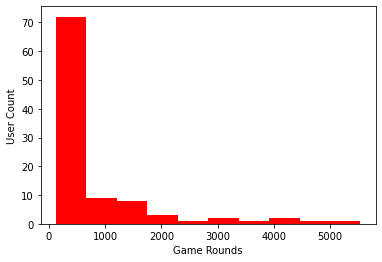

In [46]:
%matplotlib inline

plot_df = df.groupby('sum_gamerounds')['userid'].count()

ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid", kind="hist", color='red')
ax.set_xlabel("Game Rounds")
ax.set_ylabel("User Count")

## 4. One Day Retention versus Seven Day Retention
<p>The plot above shows that:</p>
<ul><li>some players install the game but then never play it (0 game rounds)</li>
<li>some players just play a couple of game rounds in their first week</li>
<li>and some get hooked to the game in the first week</li></ul>

<p>Aim is that players like the game and to get hooked to it.</p>

<p>To gauge how fun and engaging a game is <code>1-day retention</code> is calculated, which is the percentage of players that comes back and plays the game <i><b>one day</b></i> after they have installed it. Similarly, <code>7-day retention</code> is the percentage of players that comes back and plays the game <i><b>seven days</b></i> after installation.
<p><em>--->The higher the retention, the easier it is to retain players and build a large player base.</em></p>


In [47]:
one_day = df['retention_1'].sum() / df['retention_1'].count()
seven_day = df['retention_7'].sum() / df['retention_7'].count()
print('one_day = ',one_day)
print('seven_day = ',seven_day)

one_day =  0.4452095044850259
seven_day =  0.1860648194347426


## 5. One Day retention by A/B-group

<p>So, a little less than half of the players come back one day after installing the game. Looking at how ONE DAY retention differs between the two A/B-groups.</p>

In [48]:
print('Comparing Versions:')
print('1. For One Day:')
print(df.groupby('version')['retention_1'].sum() / df.groupby('version')['userid'].count())
print('')
print('2. For Seven Day:')
print(df.groupby('version')['retention_7'].sum() / df.groupby('version')['userid'].count())

Comparing Versions:
1. For One Day:
version
gate_10    0.442283
gate_5     0.448188
dtype: float64

2. For Seven Day:
version
gate_10    0.182000
gate_5     0.190201
dtype: float64


## 6. Analysing the Differences between the Versions
#### Case 1: For ONE DAY retention
<p>There is a slight decrease in ONE DAY retention when the gate is moved to level 10 (44.2%) compared to the control when it was at level 5 (44.8%). It's a small change, but even small changes in retention can have a large impact.</p>
<p>There are a couple of ways to get at the certainty of these retention numbers. Using bootstrapping the dataset can be repeatedly re-sampled (with replacement). This is followed by ONE DAY retention calculation for those samples. The variation in ONE DAY retention ultimately gives an indication of how uncertain the retention numbers can be.</p>

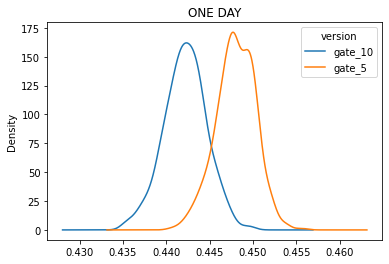

In [49]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot(kind='kde', title='ONE DAY')

#### Case 2: For SEVEN DAY retention
<p>There is a slight decrease in SEVEN DAY retention when the gate is moved to level 10 (18.20%) compared to the control when it was at level 5 (19.02%). It's a small change again.</p>
<p>Using bootstrapping followed by SEVEN DAY retention calculation for those samples, we get:</p>

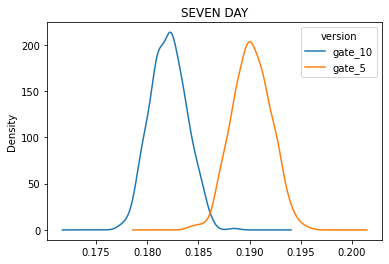

In [50]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
boot_7d.plot(kind='kde', title='SEVEN DAY')

## 7. Plotting Bootstrap Differences
<p>On zooming into the differece between retention distribution of two versions (Gate 10 and Gate 5), and plotting these for ONE DAY and SEVEN DAY retentions, we have:</p>

In [55]:
boot_1d['diff'] = (boot_1d['gate_5'] - boot_1d['gate_10']) /  boot_1d['gate_10'] * 100
boot_7d['diff'] = (boot_7d['gate_5'] - boot_7d['gate_10']) /  boot_7d['gate_10'] * 100

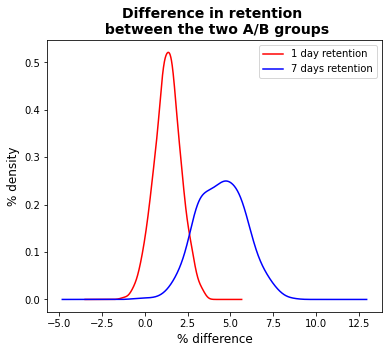

In [64]:
import matplotlib.pyplot as plt

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="red", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "blue", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

## 8. Probabilities
<p>Calculating the probability that ONE DAY retention is greater when the gate is at level 30, we get :</p>

In [67]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
print(prob_1*100,'%')

95.19999999999999 %


<p>Calculating the probability that ONE DAY retention is greater when the gate is at level 30, we get :</p>

In [68]:
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])
print(prob_7*100,'%')

99.8 %


## 9.  The Conclusion
<p>The bootstrap results tell us that there is 95.2% chance that <em>ONE DAY</em> retention is higher when the gate is at level 5 than when it is at level 10.

Similarly, there is a strong probability of 99.8% that 7-day retention is higher when the gate is at level 5 than when it is at level 10.</p>

<p>Therfore, if we want the  retention to be high for both <em>ONE DAY</em> and <em>SEVEN DAY</em> — we should not move the gate from level 5 to level 10. 

FYI - Apart from Retention, the other metrics that can be considered are:
<ul><li>Number of game rounds played</li> <li> Number of in-game purchases made by the two AB-groups</li></ul>